## Final Project Submission

Please fill out:
* Student name: Denis Kibor 
* Student pace: full time
* Scheduled project review date/time: 2/5/2025
* Instructor name: Nikita Njoroge.
* Blog post URL: 



## Introduction

In the evolving landscape of entertainment, original video content has become a powerful asset for major companies looking to expand their influence and revenue. Recognizing this trend, our company has decided to venture into the movie industry by launching a new movie studio. However, as a newcomer in this competitive space, we currently lack the insights and experience to determine what types of films will yield the greatest commercial success.

This project aims to bridge that gap.

By analyzing recent data from sources such as IMDb, bom.movie_gross and The Numbers, we will explore trends in genre, director success, language profitability, popularity, and budget efficiency over the past years. Our goal is to identify which types of films — by genre, language, or production strategy — consistently perform well at the box office.

The findings from this analysis will be translated into actionable recommendations that the company can use to make data-driven decisions on what types of films to create, how to allocate production budgets, and who to collaborate with in the filmmaking process.

## Step 1: Importing the necessary Libraries.

To perform this analysis, we use a combination of powerful Python libraries.

In [1]:
import pandas as pd 
import sqlite3
import numpy as np 
import scipy.stats as stats 
from matplotlib import pyplot as plt 
import seaborn as sns

## Step 2: Loading Datasets and Merging

In this step we will load the datasets and extract information that we will use for our analysis.

### 1. IMDB Database 
We will first look at the IMDb database. Because it's an database we will use sql to connect to it and the combine pandas and sql to create dataframes from the database.

In [2]:
conn = sqlite3.connect(r"zippedData\im.db")
conn
c = conn.cursor()

In [98]:
c.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = c.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [99]:
princ = '''SELECT * FROM principals;'''

princ_df = pd.read_sql(princ,conn)
princ_df.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [100]:
basics_query = '''SELECT * FROM movie_basics;'''

basics_df = pd.read_sql(basics_query,conn)
basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [101]:
persons_query = '''SELECT * FROM persons;'''

persons_df = pd.read_sql(persons_query,conn)
persons_df.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [102]:
directors_query = '''SELECT * FROM directors;'''

directors_df = pd.read_sql(directors_query,conn)
directors_df.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [103]:
movie_ratings_query = '''SELECT * FROM movie_ratings;'''

movie_ratings_df = pd.read_sql(movie_ratings_query,conn)
movie_ratings_df.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [57]:
combined = """SELECT *
                from principals
                JOIN movie_akas USING (movie_id)
                JOIN movie_basics USING (movie_id)
                JOIN movie_ratings USING (movie_id)
                JOIN persons USING (person_id);"""

combined_df = pd.read_sql_query(combined,conn)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422866 entries, 0 to 2422865
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   job                 object 
 5   characters          object 
 6   ordering            int64  
 7   title               object 
 8   region              object 
 9   language            object 
 10  types               object 
 11  attributes          object 
 12  is_original_title   float64
 13  primary_title       object 
 14  original_title      object 
 15  start_year          int64  
 16  runtime_minutes     float64
 17  genres              object 
 18  averagerating       float64
 19  numvotes            int64  
 20  primary_name        object 
 21  birth_year          float64
 22  death_year          float64
 23  primary_profession  object 
dtypes: float64(5), int64(4),

In [60]:
combined_df.duplicated().value_counts()

False    2422866
dtype: int64

In [64]:
imdb_df = combined_df[['category','title','region','start_year','runtime_minutes', 'genres','averagerating', 'primary_name']]
imdb_df.rename(columns={'title': 'movie'}, inplace=True)
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422866 entries, 0 to 2422865
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   category         object 
 1   movie            object 
 2   region           object 
 3   start_year       int64  
 4   runtime_minutes  float64
 5   genres           object 
 6   averagerating    float64
 7   primary_name     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 147.9+ MB


c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### 2. Rotten Tomatoes Data
We will now explore the rotten tomatoes data.

In [22]:
df_rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz',sep='\t' )
df_rt.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [23]:
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [24]:
df_rt_ratings = pd.read_csv('zippedData/bom.movie_gross.csv.gz', encoding="windows-1252")
df_rt_ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


For this project, we prioritized IMDb as our primary data source over Rotten Tomatoes for several key reasons:

- **Data Availability and Structure**: IMDb offers a more comprehensive and structured database with clear table relationships for movies, people (directors, actors), ratings, and genres. This relational structure makes it easier to perform complex joins and extract meaningful insights.

- **Granular Role Data**: IMDb allows us to directly connect contributors like directors, producers, and actors to specific movies via the `principals` table. Rotten Tomatoes does not provide this level of contributor-specific linkage in its datasets.

While Rotten Tomatoes is an excellent source for critic-based insights and sentiment, IMDb’s data was better suited for our objective: analyzing the box office performance of films based on genre, contributors, and ratings over time.


## 3. The Numbers 

To analyze the financial performance of movies, we load a dataset containing production budgets, domestic and international grosses, and release dates. This data comes from *The Numbers* and is essential for calculating net profits and evaluating the commercial success of films.


In [25]:
df_numbers = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_numbers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [26]:
df_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


## 4. Box Office Mojo

To evaluate the commercial success of movies across different regions, we load a dataset from *Box Office Mojo* containing domestic and international gross revenue figures. This data will help us analyze profitability by region and identify high-performing markets for film releases.


In [27]:
df_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [28]:
df_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [37]:
df_tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')
df_tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [48]:
# Extract only the columns we will need for our join
final_tmdb = df_tmdb[['title', 'popularity', 'original_language']] 
final_tmdb.rename(columns={'title': 'movie'}, inplace=True)
final_tmdb.head()

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,movie,popularity,original_language
0,Harry Potter and the Deathly Hallows: Part 1,33.533,en
1,How to Train Your Dragon,28.734,en
2,Iron Man 2,28.515,en
3,Toy Story,28.005,en
4,Inception,27.920,en


In [65]:
# merge information about the movies 
movie_data = pd.merge(imdb_df,final_tmdb, on='movie', how='inner')
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414347 entries, 0 to 414346
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           414347 non-null  object 
 1   movie              414347 non-null  object 
 2   region             300545 non-null  object 
 3   start_year         414347 non-null  int64  
 4   runtime_minutes    408048 non-null  float64
 5   genres             413704 non-null  object 
 6   averagerating      414347 non-null  float64
 7   primary_name       414347 non-null  object 
 8   popularity         414347 non-null  float64
 9   original_language  414347 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 34.8+ MB


In [66]:
final_df = pd.merge(movie_data, df_numbers,on='movie', how='inner')
final_df.head()

,category,movie,region,start_year,runtime_minutes,genres,averagerating,primary_name,popularity,original_language,id,release_date,production_budget,domestic_gross,worldwide_gross
0,cinematographer,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,Roger Deakins,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
1,cinematographer,"Hail, Caesar!",None,2016,106.0,"Comedy,Drama,Music",6.3,Roger Deakins,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
2,actor,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,Josh Brolin,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
3,actor,"Hail, Caesar!",None,2016,106.0,"Comedy,Drama,Music",6.3,Josh Brolin,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
4,actor,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,George Clooney,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"


In [67]:
final_df.duplicated().value_counts()

False    99622
True     12113
dtype: int64

In [68]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111735 entries, 0 to 111734
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           111735 non-null  object 
 1   movie              111735 non-null  object 
 2   region             86057 non-null   object 
 3   start_year         111735 non-null  int64  
 4   runtime_minutes    110625 non-null  float64
 5   genres             111617 non-null  object 
 6   averagerating      111735 non-null  float64
 7   primary_name       111735 non-null  object 
 8   popularity         111735 non-null  float64
 9   original_language  111735 non-null  object 
 10  id                 111735 non-null  int64  
 11  release_date       111735 non-null  object 
 12  production_budget  111735 non-null  object 
 13  domestic_gross     111735 non-null  object 
 14  worldwide_gross    111735 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1

In [69]:
df = final_df.copy()
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99622 entries, 0 to 111734
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           99622 non-null  object 
 1   movie              99622 non-null  object 
 2   region             76249 non-null  object 
 3   start_year         99622 non-null  int64  
 4   runtime_minutes    98555 non-null  float64
 5   genres             99504 non-null  object 
 6   averagerating      99622 non-null  float64
 7   primary_name       99622 non-null  object 
 8   popularity         99622 non-null  float64
 9   original_language  99622 non-null  object 
 10  id                 99622 non-null  int64  
 11  release_date       99622 non-null  object 
 12  production_budget  99622 non-null  object 
 13  domestic_gross     99622 non-null  object 
 14  worldwide_gross    99622 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 12.2+ MB


In [70]:
df.head()

,category,movie,region,start_year,runtime_minutes,genres,averagerating,primary_name,popularity,original_language,id,release_date,production_budget,domestic_gross,worldwide_gross
0,cinematographer,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,Roger Deakins,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
1,cinematographer,"Hail, Caesar!",None,2016,106.0,"Comedy,Drama,Music",6.3,Roger Deakins,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
2,actor,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,Josh Brolin,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
3,actor,"Hail, Caesar!",None,2016,106.0,"Comedy,Drama,Music",6.3,Josh Brolin,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"
4,actor,"Hail, Caesar!",GB,2016,106.0,"Comedy,Drama,Music",6.3,George Clooney,12.312,en,22,"Feb 5, 2016","$22,000,000","$30,080,225","$64,160,680"


In [73]:
# Remove $ and commas, convert to float
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

# Step 2: Drop rows where any of the key columns are missing
df_profit = df.dropna(subset=['category', 'primary_name', 'profit'])

# Step 3: Filter for directors only
df_directors = df_profit[df_profit['category'] == 'director']

# Step 4: Group by director's name and calculate average profit
director_profit = df_directors.groupby('primary_name')['profit'].mean().reset_index()

# Step 5: Sort by average profit (highest first)
director_profit = director_profit.sort_values(by='profit', ascending=False)

# Step 6: Display top 20 most profitable directors
director_profit.head(20)

,primary_name,profit
159,Atsushi Wada,2.351345e+09
909,Joe Russo,1.295256e+09
135,Anthony Russo,1.295256e+09
377,Colin Trevorrow,1.255082e+09
1722,Samuel Perriard,1.148258e+09
12,Adam Green,1.122470e+09
317,Chris Buck,1.122470e+09
865,Jennifer Lee,1.122470e+09
312,Chi-kin Kwok,1.122470e+09
1129,Kyle Balda,1.065235e+09


### Bar Chart(Top 20 Directors by Average Earnings)

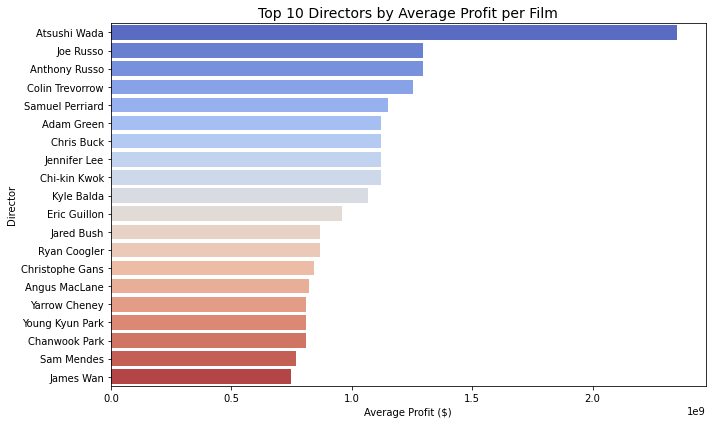

In [75]:
# Take top 10 profitable directors
top_profit_directors = director_profit.head(20)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_profit_directors, x='profit', y='primary_name', palette='coolwarm')
plt.title('Top 10 Directors by Average Profit per Film', fontsize=14)
plt.xlabel('Average Profit ($)')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

### Bubble Plot: Budget vs Net Income (Unique Movies)

This bubble chart visualizes the relationship between a movie's **production budget** and its resulting **net income**, considering only **unique movies** to eliminate duplication from multiple categories like cast and crew.
ter

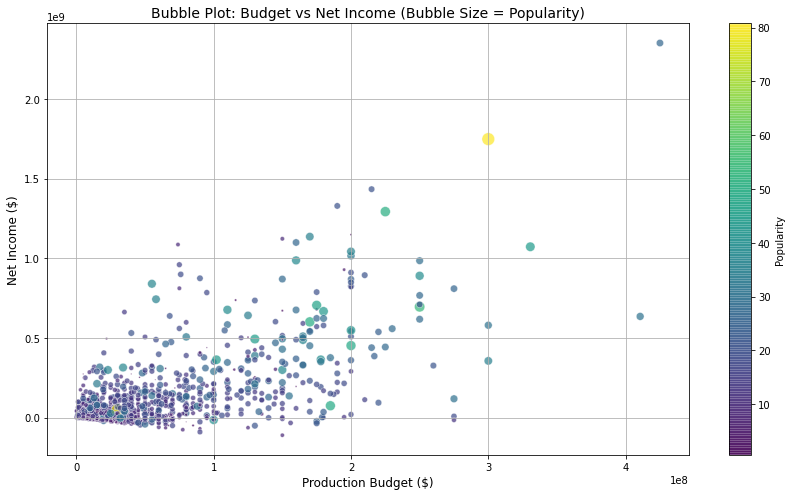

In [97]:
import matplotlib.pyplot as plt

# Step 1: Create net_income column if not already present
df['net_income'] = df['worldwide_gross'] - df['production_budget']

# Step 2: Drop duplicates to isolate unique movies (based on title or movie_id)
unique_movies_df = df.drop_duplicates(subset='movie')

# Step 3: Prepare DataFrame for plotting
plot_df = unique_movies_df[['production_budget', 'net_income', 'popularity']].dropna()

# Step 4: Create bubble plot
plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    plot_df['production_budget'],
    plot_df['net_income'],
    s=plot_df['popularity'] * 2,  # Bubble size
    alpha=0.7,
    c=plot_df['popularity'],      # Color by popularity
    cmap='viridis',
    edgecolors='w',
    linewidth=0.5
)

plt.title('Bubble Plot: Budget vs Net Income (Bubble Size = Popularity)', fontsize=14)
plt.xlabel('Production Budget ($)', fontsize=12)
plt.ylabel('Net Income ($)', fontsize=12)
plt.colorbar(scatter, label='Popularity')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Observations
- Most movies with lower production budgets cluster around low-to-moderate net incomes.
- A few high-budget films yield exceptionally high net incomes, indicating big-budget blockbusters can pay off.
- Outliers with large, brightly colored bubbles highlight movies that were both popular and financially successful.
- Some movies with high budgets still performed poorly (bubbles close to the X-axis), underscoring financial risk.

This plot helps spot financial winners and underperformers at a glance while factoring in audience appeal.


In [87]:
df.columns

Index(['category', 'movie', 'region', 'start_year', 'runtime_minutes',
       'genres', 'averagerating', 'primary_name', 'popularity',
       'original_language', 'id', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'net_income'],
      dtype='object')

### Correlation Heatmap: Numerical Variables.
This heatmap illustrates the relationships between key numerical features for unique movies in our dataset. Correlation values range from -1 (perfect negative correlation) to 1 (perfect positive correlation).

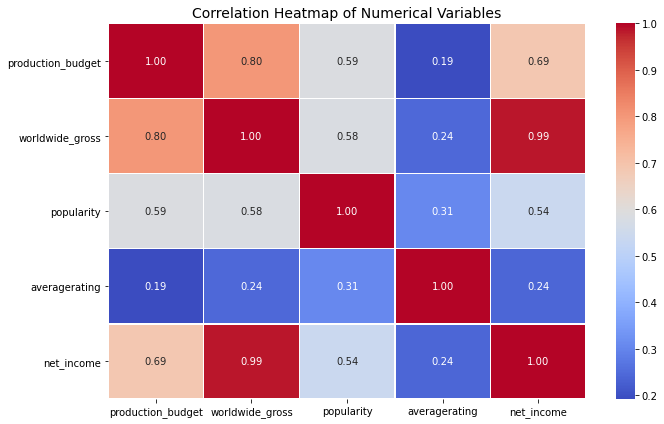

In [93]:
unique_movies_df = df.drop_duplicates(subset='movie')

# Select numerical columns to check correlation
correlation_df = unique_movies_df[['production_budget', 'worldwide_gross', 'domestic_gross', 'popularity', 'averagerating', 'net_income']].dropna()

# Compute correlation matrix
corr_matrix = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14)
plt.tight_layout()
plt.show()

#### Observations:

- **WorldWide Gross vs Net Income (0.99)**:  
  As expected, there's a nearly perfect positive correlation. Higher worldwide revenue almost always results in higher profit.

- **Production Budget vs Worldwide Gross (0.80)**:  
  A strong positive relationship exists — movies with larger budgets tend to earn more globally. However, high spending doesn’t always guarantee higher profit.

- **Production Budget vs Net Income (0.69)**:  
  Bigger budgets often lead to higher net income, although there's still some variability.

- **Popularity (0.54–0.59 with financials)**:  
  Popularity shows moderate correlation with budget, revenue, and net income, suggesting that buzz and visibility contribute to a movie’s financial performance.

- **Average Rating (0.19–0.31 with other metrics)**:  
  Ratings show weak correlation with financial outcomes. This indicates that a highly-rated film is not necessarily a top earner.


### Boxplot: Net Income by Genre

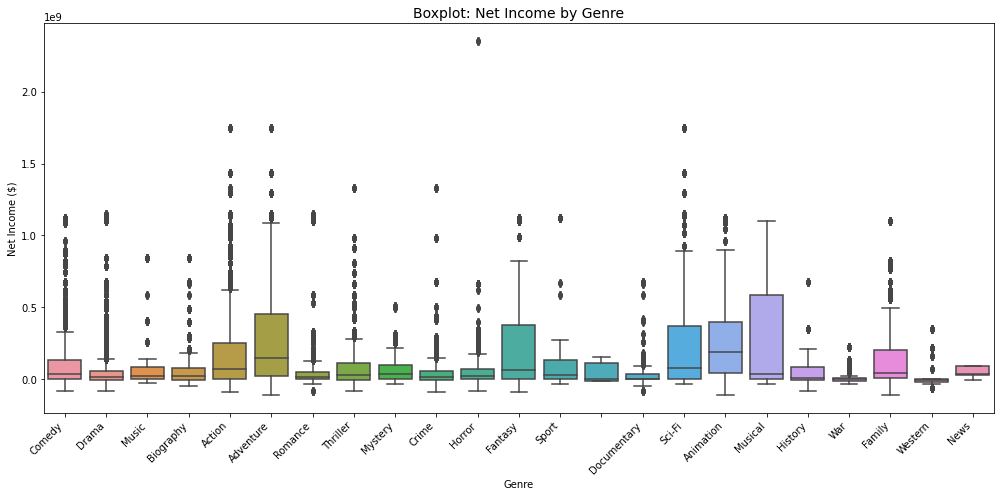

In [92]:
df_exploded = df.copy()
df_exploded['genres'] = df_exploded['genres'].fillna('').str.split(',')
df_exploded = df_exploded.explode('genres')
df_exploded['genres'] = df_exploded['genres'].str.strip()

# Drop rows with missing or zero net income
boxplot_df = df_exploded[['genres', 'net_income']].dropna()
boxplot_df = boxplot_df[boxplot_df['net_income'] != 0]

# Plot boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(data=boxplot_df, x='genres', y='net_income')
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot: Net Income by Genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Net Income ($)')
plt.tight_layout()
plt.show()


The boxplot above visualizes the distribution of net income across different movie genres. Each box represents the interquartile range (IQR), with the line inside indicating the median net income for that genre. Outliers are plotted as individual points.

This visualization helps identify which genres tend to generate higher profits. For example, <b>genres such as Adventure, Animation, Musical, Sci-Fi and Fantasy</b>show both higher medians and wider spreads, indicating they can be very lucrative but also variable. In contrast, genres like Biography, Romance, and War generally display lower net income and narrower distributions.